# **Manipuler les DataArray**

Les DataArrays (<mark>***DataArrayInt***</mark> et <mark>***DataArrayDouble***</mark>) sont utilisés dans MEDCoupling pour stocker des valeurs sous forme de tableaux contigus en mémoire. Les valeurs sont groupées par tuples, et chaque tuple a le même nombre de composantes. Ils sont à la base de beaucoup de traitements réalisés dans MEDCoupling. Il est ainsi important de bien savoir les manipuler.

Les <mark>***DataArrayDouble***</mark> sont souvent utilisés pour la manipulation directe des valeurs d’un champ comme on le verra plus tard. Les <mark>***DataArrayInt***</mark> eux sont utilisés pour toutes les fonctionnalités travaillant avec des identifiants de cellules et/ou de points.


## **Le but de l’exercice**

Le but ici est de créer les coordonnées de 7 hexagones réguliers (tous inscrits dans des cercles de rayon 3m) en dimension 2. La première composante du tableau de coordonnées s’appelera X avec l’unité "m" (mètre) et la 2ème composante s’appelera "Y" avec la même unité.

On pourrait directement calculer les coordonnées de l’ensemble des points requis avec un peu de trigonométrie, mais afin de travailler un peu avec l’API, on fait le choix de construire les 7 hexagones à partir d’un seul hexagone régulier centré en $[3.4; 4.4]$. Autour de cet hexagone régulier central, on crée 6 copies translatées et chaque copie partagera exactement un bord (edge) avec le motif initial. Ensuite on fusionne les noeuds (tuples) communs. Ceci nous permettra de manipuler les indirections et les méthodes d’indexing très usitées dans les maillages non structurés.


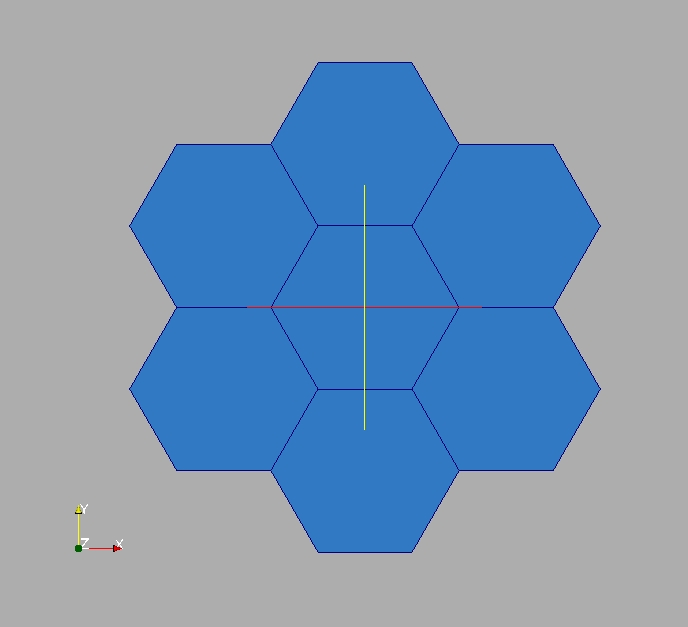

In [1]:
from IPython.display import Image
display(Image(filename="hexagon.jpg" ,width=500,height=500))

Les points traités ici :

>- Créer une instance de <mark>***DataArrayDouble***</mark>
>- Afficher une instance de <mark>***DataArrayDouble***</mark> et invoquer la méthode <mark>***getValue()***</mark> pour la convertir en liste
>- Utiliser les notations pratiques ***$da[:,:]$*** ...
>- Apprendre la renumérotation (convention "old-2-new")
>- Invoquer des services tels que <mark>***findCommonTuples()***</mark>

## **Début de l’implémentation**

Pour commencer l’exercice importer le module Python **medcoupling** et l’aliaser avec **mc** (ca nous évitera des noms trop longs). Importer aussi le module **math**.

In [2]:
import medcoupling as mc
import math

On rappelle que toutes les méthodes statiques du module commencent par une majuscule. Avec ces imports sont disponibles :

> - toutes les classes de MEDCoupling
> - tous les énumérations (par exemple, les types de cellules standard: <mark>***mc.ON_CELLS***</mark>, <mark>***mc.ON_NODES***</mark>, <mark>***mc.ONE_TIME***</mark> ...)
> - toutes les méthodes statiques

## **Créer une instance de DataArrayDouble contenant 6 tuples**

Le but ici est de créer un <mark>***DataArrayDouble***</mark> contenant les coordonnées d’un seul hexagone régulier.

In [3]:
d = mc.DataArrayDouble(6,2)

Ceci est équivalent à

In [4]:
d = mc.DataArrayDouble()
d.alloc(6,2)

Ceci est aussi équivalent à

In [5]:
d = mc.DataArrayDouble(12)
d.rearrange(2)

Notons enfin que l’on peut aussi directement construire un <mark>***DataArray***</mark> à partir d’une liste Python. Par défaut le tableau n’a qu’une seule composante.

In [6]:
d_example = mc.DataArrayDouble([0.0,1.0,2.5])
# print(d_example )

<div class="alert alert-block alert-success">
<b>Note:</b> Le tableau d contient maintenant 12 valeurs groupées en 6 tuples contenant chacun 2 composantes. Les valeurs dans d ne sont pas encore assignées.</div>

## **Initialiser une instance de DataArrayDouble**

Assigner la valeur 3.0 (le rayon) à la première composante de chacun des tuples. La syntaxe ressemble fortement à celle de NumPy. On peut par exemple assigner d’un coup les tuples 1 à 3 (inclus), sur la première composante avec la valeur 3.0

In [7]:
d[1:4,0] = 3.

ou directement l’intégralité de la première composante

In [8]:
d[:,0] = 3.

Initialiser la 2ème composante de chaque tuple i avec la valeur i.

In [9]:
d[:,1] = list(range(6))

Multiplier la seconde composante de chacun des tuples par pi/3.

In [10]:
d[:,1] *= math.pi/3.


<div class="alert alert-block alert-success">
<b>Note:</b>
"d" contient désormais les coordonnées polaires des noeuds de notre hexagone régulier centré en 0,0 pour le moment.</div>

Convertir d de polaire à cartésien en invoquant la méthode <mark>***fromPolarToCart()***</mark> et re-mettre le résultat dans d.

In [11]:
d = d.fromPolarToCart()

<div class="alert alert-block alert-danger">
<b>Note:</b> fromPolarToCart() génère une nouvelle instance, nous avons donc perdu le d initial.</div>

Assigner les informations textuelles correctes sur les 2 composantes de d :

In [12]:
d.setInfoOnComponents(["X [m]","Y [m]"])

<div class="alert alert-block alert-success">
<b>Note:</b>
Cela n’est pas indispensable pour cet exercise, mais d’autres fonctions plus avancées nécessitent cette information.</div>

Afficher d tel quel.

In [13]:
# print(d)

Afficher juste les valeurs sous forme d’une liste python.

In [14]:
# print(d.getValues())

Vérifier que pour chaque tuple désormais dans d, sa norme (méthode <mark>***magnitude()***</mark> ) est bien égale à 3.0, à 1.e-12 près (méthode <mark>***isUniform()***</mark> )

In [15]:
# print("Uniform array?", d.magnitude().isUniform(3.,1e-12))

## **Duplication et agrégation**

On construit maintenant la liste <mark>***translationToPerform***</mark>, qui contient une liste de vecteurs chacun de taille 2. Cette liste de taille 7 (7 hexagones) contient la translation à opérer pour produire chacun des hexagones.

Faites nous confiance sur la trigonométrie, vous pouvez copier directement les deux lignes suivantes

In [16]:
radius = 3.
translationToPerform = [[0.,0.],[3./2.*radius,-radius*math.sqrt(3.)/2],[3./2.*radius,radius*math.sqrt(3.)/2],[0.,radius*math.sqrt(3.)],[-3./2.*radius,radius*math.sqrt(3.)/2],[-3./2.*radius,-radius*math.sqrt(3.)/2],[0.,-radius*math.sqrt(3.)]]

Créer les 7 copies de d et opérer la “translation” correspondante.

In [17]:
ds = len(translationToPerform)*[None]
for pos,t in enumerate(translationToPerform):
        ds[pos] = d[:]      # Perform a deep copy of d and place it at position 'pos' in ds
        ds[pos] += t        # Adding a vector to a set of coordinates does a translation. t could have been a DataArrayDouble too.
        pass

<div class="alert alert-block alert-success">
<b>Note:</b>
Le pass à la fin de la boucle for n’est pas indispensable mais aide certains éditeurs à indenter le code.</div>

Une autre façon de faire un peu plus compacte (pour les amoureux des one-liner) :

In [18]:
ds = [d + translationToPerform[i] for i in list(range(len(translationToPerform)))]

## **Agrégation de tableaux**

A partir de la liste d’instances de DataArrayDouble ds construire le DataArrayDouble d2 résultat de l’agrégation des instances les unes à la suite des autres.

In [19]:
d2 = mc.DataArrayDouble.Aggregate(ds)

d2 contient désormais l’ensemble des tuples (6*7 de 2 composantes chacun) des instances contenues dans ds, en respectant l’ordre dans ds. Cela parait évident, mais l’agrégation de maillages et de champs respecte exactement le même principe pour faciliter l’accès et le repérage des données. C’est par exemple une différence essentielle avec le modèle MED fichier comme on le verra plus tard.

<div class="alert alert-block alert-success">
<b>Note:</b>
La méthode permettant d’agréger par composante (c’est-à-dire de concaténer des tableaux colonne par colonne, plutôt que par tuples) s’appelle Meld().</div>

## **Trouver les tuples égaux**

La variable d2 contient 42 tuples mais certains tuples apparaissent plusieurs fois. Pour trouver les tuples égaux à 1e-12 près (précision absolue) invoquer <mark>***findCommonTuples()***</mark>. Utiliser help(mc.DataArrayDouble.findCommonTuples) pour en connaitre l’interface. Stocker le retour de la fonction dans c et cI

In [20]:
oldNbOfTuples = d2.getNumberOfTuples()
c,cI = d2.findCommonTuples(1e-12)

On a ainsi récupéré dans c l’ensemble des m=12 groupes de noeuds communs accollés. cI contient les index pour repérer les identifiants de points dans c pour tout groupe i dans $[0,12)$. Ainsi les identifiants de tuples du groupe i commencent à l’index cI[i] et finissent à l’index cI[i+1].

La méthode <mark>***findCommonTuples()***</mark> retourne ainsi 2 paramètres: un tableau contenant la liste des tuples communs et un tableau d’index qui permet de naviguer dans le premier tableau. Il s’agit d’une forme de retour très classique dans MEDCoupling, appelée indirect indexing. Cela apparaît souvent dans la manipulation des maillages non structurés. Cette représentation est rappelée sur l’image ci-dessous, où le premier tableau est en haut, et le deuxième tableau permettant de la parcourir en bas:

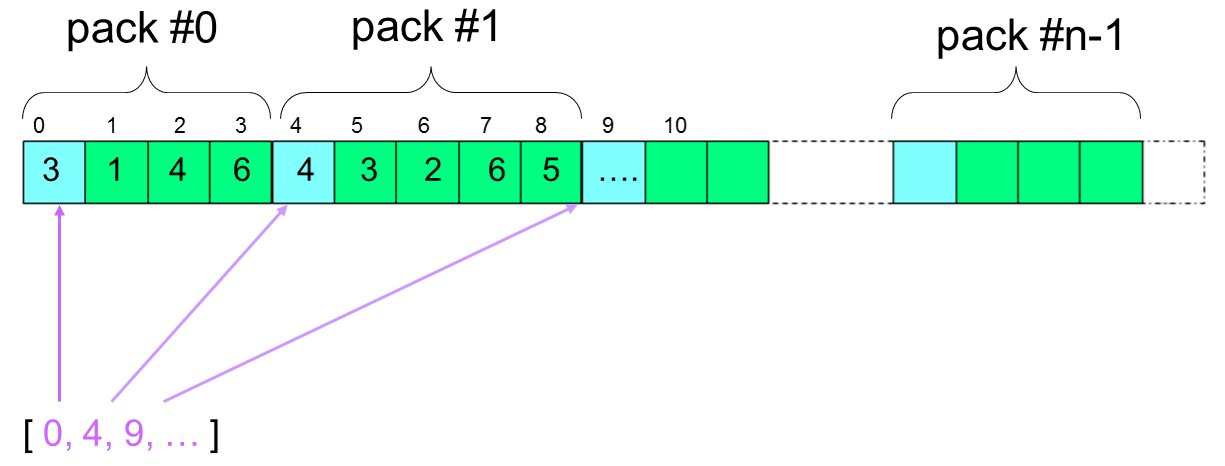

In [21]:
display(Image(filename="IndirectIndex.jpg" ,width=700,height=500))

<div class="alert alert-block alert-success">
<b>Note:</b>
Le dernier élément de cI pointe en dehors du tableau c. Ce dernier index est toujours présent et permet de s’assurer que des traitements tels que les slices présentés juste après, sont toujours valables, sans avoir besoin de particulariser le dernier groupe.</div>

## **Manipuler le format “indirect index”**

Le nombre de tuples communs à 1e-12 près est donc égal à len(cI)-1, c’est-à-dire 12 dans notre cas. Récupérer la liste des identifiants de tuples du groupe 0 et mettre le résultat dans la variable tmp. Afficher tmp.

In [22]:
tmp = c[cI[0]:cI[0+1]]
# print(tmp)

Vérifier, en l’affichant, que pour tous les identifiants de tuples dans tmp, leurs tuples sont bien égaux dans d2.

In [23]:
# print(d2[tmp])

<div class="alert alert-block alert-success">
<b>Note:</b>
On voit que le tuple $(3.,0.)$ à 1e-12 près est répété 3 fois et tmp donne les positions respectives de ces 3 répétitions.</div>

Maintenant on va déduire des variables <mark>***oldNbOfTuples***</mark>, c et cI le nombre de tuples effectivement différents dans d2. Pour ce faire, nous allons trouver le nombre de tuples doublons dans d2 et soustraire le résultat de <mark>***oldNbOfTuples***</mark>.

Pour connaître le nombre de doublons, invoquer <mark>***DataArrayInt.deltaShiftIndex***</mark> qui retourne pour chaque groupe sa taille. Mettre le résultat dans a.

In [24]:
a = cI.deltaShiftIndex()

Déduire de a le nombre de tuples doublons dans d2 par groupe et mettre le résultat dans b.

In [25]:
b = a-1

Enfin on peut trouver le nouveau nombre de tuples grâce à b et à <mark>***oldNbOfTuples***</mark>. Mettre le résultat dans <mark>***myNewNbOfTuples***</mark>.

In [26]:
myNewNbOfTuples = oldNbOfTuples - sum(b.getValues())

## **Construire un tableau “old-2-new”**

Nous allons maintenant exploiter cette information pour extraire un seul représentant dans chaque groupe de points dupliqués.

Les deux tableaux c et cI définissent une surjection d’un espace de départ à 42 (<mark>***oldNbOfTuples***</mark>) tuples X vers un espace à 24 (<mark>***myNewNbOfTuples***</mark>) tuples Y.

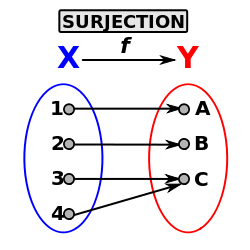

In [27]:
display(Image(filename="SurjectionDataArray.png" ,width=250,height=500))

L’autre manière de définir cette surjection (sans perte d’information) est de la représenter par un tableau “old-2-new”. Ce mode de stockage prend la forme d’un DataArrayInt ***o2n*** composé de Card(X) tuples (i.e. 42) à une composante. Pour chaque tuple (élément) d’index i de ***o2n***, la case ***o2n[i]*** contient le nouvel identifiant de tuple dans Y. On va donc d’un ancien identifiant (old) vers un nouveau (new).

Nous allons construire ce tableau pour extraire un sous-ensemble des coordonnées de départ, et ne garder que les tuples uniques (non doublons) dans l’ensemble de départ.

<div class="alert alert-block alert-success">
<b>Note:</b>
Pour toutes les opérations de renumérotation en MEDCoupling (bijection), le format “old-2-new” est systématiquement utilisé.</div>

La méthode statique <mark>***DataArrayInt.ConvertIndexArrayToO2N()***</mark> (nom un peu barbare, on vous l’accorde) permet de passer du mode de stockage de cette surjection c, cI au format o2n. On récupère au passage card(Y) c’est-à-dire le <mark>***newNbOfTuples***</mark>.

In [28]:
o2n, newNbOfTuples = mc.DataArrayInt.ConvertIndexArrayToO2N(oldNbOfTuples,c,cI)
# print("Have I got the right number of tuples?")
# print("myNewNbOfTuples = %d, newNbOfTuples = %d" % (myNewNbOfTuples, newNbOfTuples))
assert(myNewNbOfTuples == newNbOfTuples)

Nous pouvons maintenant constuire le tableau de points uniques d3. A l’aide de o2n et <mark>***newNbOfTuples***</mark>, invoquer <mark>***DataArrayDouble.renumberAndReduce()***</mark> sur d2.

In [29]:
d3 = d2.renumberAndReduce(o2n, newNbOfTuples)

L’inconvénient de cette méthode c’est que finalement on ne connait pas pour chaque groupe de tuple communs dans d2 quel identifiant a été utilisé. Par exemple pour le groupe 0 on sait que les tuples 0, 8 et 16 (tmp.getValues()) sont tous égaux, et on ne sait pas si 0, 8 ou 16 a été utilisé pour remplir d3.

Si l’on souhaite expliciter ce choix, on peut passer en format “new-2-old”. Ce mode de stockage prend la forme d’un <mark>***DataArrayInt***</mark> n2o composé de Card(Y) tuples (24) à 1 composante. Pour chaque tuple (élément) d’index i de n2o, la case n2o[i] contient l’index du tuple qui a été choisi dans X.

Pour passer d’une description “old-2-new” vers “new-2-old”, la méthode est <mark>***DataArrayInt.invertArrayO2N2N2O()***</mark>. Effectuer ce traitement sur la variable o2n.

In [30]:
n2o = o2n.invertArrayO2N2N2O(newNbOfTuples)

A l’aide de n2o on peut construire un d3_bis à partir de d2, et qui contient la même chose que le d3 précédent.

In [31]:
d3_bis = d2[n2o]
# print("Are d3 and d3_bis equal ? %s" % (str(d3.isEqual(d3_bis, 1e-12))))

## **Translater tous les tuples**

Tous les tuples (ou nodes) sont à translater du vecteur [3.3,4.4] afin de recentrer toute la figure en ce point.

In [32]:
d3 += [3.3,4.4]

## **Constuire un maillage non structuré**

On chercher maintenant à créer le maillage final montré dans la figure. Nous avons déjà construit le tableau de coordonnées, il nous reste les cellules à créer.

Créer un maillage non structuré m avec les coordonnées d3. Le maillage``m`` a une mesh-dimension 2

In [33]:
m = mc.MEDCouplingUMesh("My7hexagons",2)
m.setCoords(d3)
# print("Mesh dimension is", m.getMeshDimension())
# print("Spatial dimension is", m.getCoords().getNumberOfComponents())

Maintenant, allouer le nombre de cellules avec (un majorant du) nombre attendu de cellules.

In [34]:
m.allocateCells(7)

Enfin grâce à o2n on a la connectivité (i.e. la liste des points formant un hexagone) des 7 hexagones utilisant les coordonnées d3.

In [35]:
for i in range(7):
        cell_connec = o2n[6*i:6*(i+1)]
        m.insertNextCell(mc.NORM_POLYGON, cell_connec.getValues())
        pass

Vérifier que m est correct et ne contient pas d’anomalie.

In [36]:
m.checkConsistencyLight()

<div class="alert alert-block alert-success">
<b>Note:</b>
Il est toujours une bonne idée d’appeler cette méthode après la construction “from scratch” d’un maillage. Cela assure qu’il n’y a pas de gros “couacs” dans la connectivité, etc... </div>

Pour vérifier visuellment que m est correct, l’écrire dans un fichier “My7hexagons.vtu” et le visualiser dans ParaViS.

In [37]:
# m.writeVTK("My7hexagons.vtu")

<div class="alert alert-block alert-success">
<b>Note:</b>
On a écrit ici dans un fichier VTU et non MED, car MEDCoupling n’inclut pas par défaut les services de MED fichier. Bien que l’on écrive au format VTK (*.vtu), MEDCoupling ne dépend pas de VTK.</div>